# Install the required packages

In [1]:
%pip install kagglehub
%pip install pandas
%pip install -U jupyter ipywidgets
%pip install -U jupyterlab-widgets
%pip install scikit-learn
%pip install imbalanced-learn
%pip install tabulate

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# Download the dataset and load datas

In [2]:
import os
import kagglehub

path = kagglehub.dataset_download("elemento/nyc-yellow-taxi-trip-data")
file_path1 = os.path.join(path, "yellow_tripdata_2015-01.csv")  # Path to the dataset file
file_path2 = os.path.join(path, "yellow_tripdata_2016-01.csv")  # Path to the dataset file
file_path3 = os.path.join(path, "yellow_tripdata_2016-02.csv")  # Path to the dataset file
file_path4 = os.path.join(path, "yellow_tripdata_2016-03.csv")  # Path to the dataset file

In [3]:
# Verifica degli attributi presenti
import pandas as pd
df_sample = pd.read_csv(file_path1, nrows=5)
print(df_sample.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


# Load only the needed columns

In [4]:
import pandas as pd

needed_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tip_amount",            # Importo della mancia
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
    "tpep_pickup_datetime",  # Data e ora di inizio del viaggio
    "payment_type"           # Tipo di pagamento (target)
]

df_2015_01 = pd.read_csv(file_path1, usecols=needed_columns)    # Load the dataset  in a DataFrame
df_2016_01 = pd.read_csv(file_path2, usecols=needed_columns)    # Load the dataset  in a DataFrame
df_2016_02 = pd.read_csv(file_path3, usecols=needed_columns)    # Load the dataset  in a DataFrame
df_2016_03 = pd.read_csv(file_path4, usecols=needed_columns)    # Load the dataset  in a DataFrame

# Join the different dataframes

In [5]:
df = pd.concat([df_2015_01, df_2016_01, df_2016_02, df_2016_03], ignore_index=True)
print (df.columns)

Index(['tpep_pickup_datetime', 'passenger_count', 'trip_distance',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')


# Transformation: managing null values (if exist)

In [6]:
def check_null_values(df):
    if df.isnull().values.any():
        print("Il DataFrame contiene valori nulli.")
        # Mostra le colonne con valori nulli e il conteggio di tali valori
        null_columns = df.isnull().sum()
        print("Colonne con valori nulli:")
        print(null_columns[null_columns > 0])
    else:
        print("Non ci sono valori nulli nel DataFrame.")
        
check_null_values(df)

Il DataFrame contiene valori nulli.
Colonne con valori nulli:
improvement_surcharge    3
dtype: int64


In [7]:
# Dato che i valori nulli sono pochi, possiamo eliminare i record contenenti i valori nulli
num_rows_before = df.shape[0]
print(num_rows_before)
df_cleaned = df.dropna()
num_rows_after = df_cleaned.shape[0]
print(num_rows_after)

47248845
47248842


# Verifying the balance of the dataset

In [8]:
# Conta le occorrenze di ciascun codice di pagamento
payment_type_counts = df_cleaned['payment_type'].value_counts()

# Stampa i risultati
print("Conteggio delle righe per ciascun codice di pagamento:")
print(payment_type_counts)

# No charge payment significa che il passeggero non è stato addebitato per il viaggio.
# Dispute payment indica che il pagamento è stato contestato dal cliente.
# Non essendo rilevanti ai fini dell'analisi, abbiamo deciso di eliminare le righe che presentano payment type pari a 3, 4, 5

# Elimina le righe con valori 3, 4, o 5 nella colonna 'payment_type'
df_filtered = df_cleaned[~df_cleaned['payment_type'].isin([3, 4, 5])]
print("Nuovo numero di righe: ")
print(df_filtered.shape[0])

Conteggio delle righe per ciascun codice di pagamento:
payment_type
1    30870611
2    16158086
3      164138
4       56004
5           3
Name: count, dtype: int64
Nuovo numero di righe: 
47028697


# Transformation: normalizing the values

In [9]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tip_amount",            # Importo della mancia
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
]

def normalize_numeric_columns(df, numeric_columns):
    # Inizializza lo scaler per la normalizzazione
    scaler = MinMaxScaler()
    # Normalizza solo le colonne numeriche
    df.loc[:, numeric_columns] = scaler.fit_transform(df[numeric_columns])
    return df

# Normalizzazione delle colonne numeriche
df_normalized = normalize_numeric_columns(df_filtered, numeric_columns)
# print(df_normalized)
print(df_normalized.columns)

# Seleziona solo le colonne specificate in numeric_columns
numeric_df_normalized = df_normalized[numeric_columns]
# print (numeric_df_normalized)
print(numeric_df_normalized.columns)

/var/folders/cw/r79hxm697kv7jz3npd6fb6l80000gn/T/ipykernel_4597/3935103675.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.11111111 0.11111111 0.11111111 ... 0.11111111 0.11111111 0.11111111]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, numeric_columns] = scaler.fit_transform(df[numeric_columns])


Index(['tpep_pickup_datetime', 'passenger_count', 'trip_distance',
       'payment_type', 'fare_amount', 'extra', 'mta_tax', 'tip_amount',
       'tolls_amount', 'improvement_surcharge', 'total_amount'],
      dtype='object')
Index(['trip_distance', 'fare_amount', 'extra', 'mta_tax',
       'improvement_surcharge', 'tip_amount', 'tolls_amount', 'total_amount',
       'passenger_count'],
      dtype='object')


# Using get_dummies() for tpep_pickup_datetime and payment_type features

In [10]:
# A seconda del momento della giornata in cui inizia la corsa, il prezzo totale può cambiare
def get_period(hour):
    if 6 <= hour < 18:
        return 'giorno'
    else:
        return 'notte'

# Converti le colonne in formato datetime
df_normalized['tpep_pickup_datetime'] = pd.to_datetime(df_normalized['tpep_pickup_datetime'])
# Crea una nuova colonna "pickup_period" per indicare giorno o notte
df_normalized['pickup_period'] = df_normalized['tpep_pickup_datetime'].dt.hour.apply(get_period)
print(df_normalized)

/var/folders/cw/r79hxm697kv7jz3npd6fb6l80000gn/T/ipykernel_4597/1009854752.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['tpep_pickup_datetime'] = pd.to_datetime(df_normalized['tpep_pickup_datetime'])


         tpep_pickup_datetime  passenger_count  trip_distance  payment_type  \
0         2015-01-15 19:05:39         0.111111       0.150939             1   
1         2015-01-10 20:33:38         0.111111       0.150940             1   
2         2015-01-10 20:33:38         0.111111       0.150939             2   
3         2015-01-10 20:33:39         0.111111       0.150939             2   
4         2015-01-10 20:33:39         0.111111       0.150940             2   
...                       ...              ...            ...           ...   
47248840  2016-03-31 16:34:36         0.111111       0.150939             2   
47248841  2016-03-26 03:02:32         0.111111       0.150939             1   
47248842  2016-03-20 08:43:59         0.111111       0.150940             1   
47248843  2016-03-20 08:49:47         0.111111       0.150940             1   
47248844  2016-03-20 08:50:24         0.111111       0.150940             1   

          fare_amount     extra   mta_tax  tip_amou

/var/folders/cw/r79hxm697kv7jz3npd6fb6l80000gn/T/ipykernel_4597/1009854752.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_normalized['pickup_period'] = df_normalized['tpep_pickup_datetime'].dt.hour.apply(get_period)


In [11]:
# Usa get_dummies per trasformare la colonna pickup_period in one-hot encode
# 1 è notte, 0 è giorno

# Applica get_dummies per trasformare la colonna pickup_period in variabili dummy
df_normalized = pd.get_dummies(df_normalized, columns=['pickup_period'], drop_first=True)

# Crea e converte pickup_period_notte da booleano a intero (1 per True , 0 per False)
df_normalized['pickup_period_notte'] = df_normalized['pickup_period_notte'].astype(int)
# Crea una colonna binaria 'payment_type_creditCard' che è 1 se 'payment_type' è 1, altrimenti 0
df_normalized['payment_type_creditCard'] = (df_normalized['payment_type'] == 1).astype(int)

print(df_normalized)


         tpep_pickup_datetime  passenger_count  trip_distance  payment_type  \
0         2015-01-15 19:05:39         0.111111       0.150939             1   
1         2015-01-10 20:33:38         0.111111       0.150940             1   
2         2015-01-10 20:33:38         0.111111       0.150939             2   
3         2015-01-10 20:33:39         0.111111       0.150939             2   
4         2015-01-10 20:33:39         0.111111       0.150940             2   
...                       ...              ...            ...           ...   
47248840  2016-03-31 16:34:36         0.111111       0.150939             2   
47248841  2016-03-26 03:02:32         0.111111       0.150939             1   
47248842  2016-03-20 08:43:59         0.111111       0.150940             1   
47248843  2016-03-20 08:49:47         0.111111       0.150940             1   
47248844  2016-03-20 08:50:24         0.111111       0.150940             1   

          fare_amount     extra   mta_tax  tip_amou

# Feature Correlation

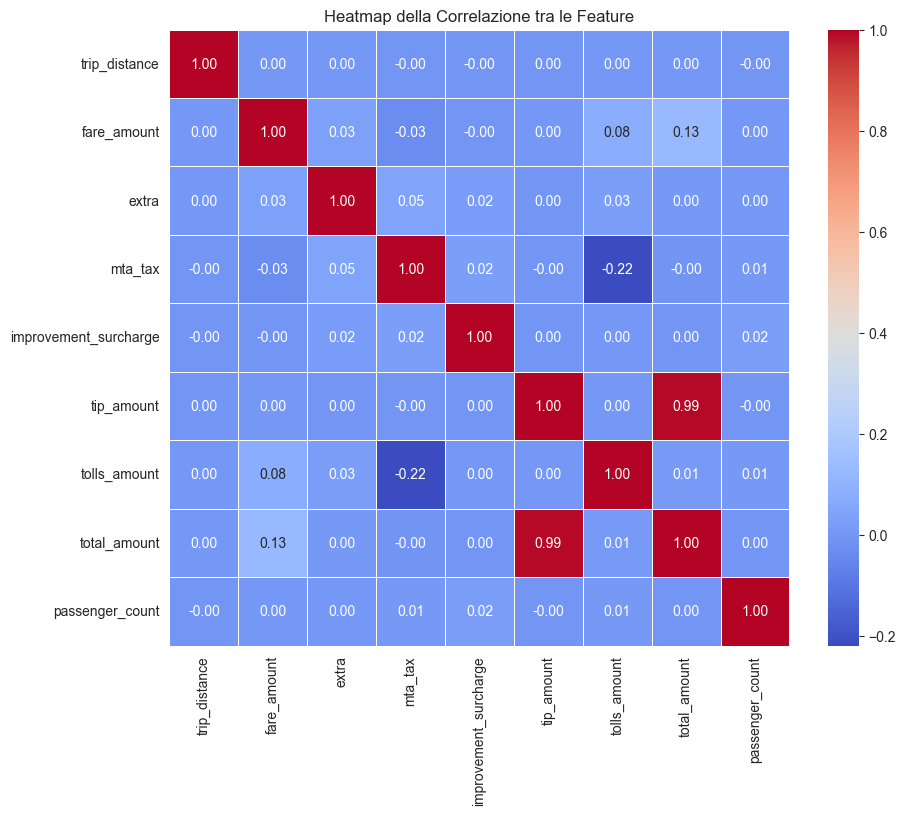

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcola la matrice di correlazione (tiene in considerazione solo gli attributi numerici)
correlation_matrix = numeric_df_normalized.corr()

# Imposta la dimensione della figura
plt.figure(figsize=(10, 8))

# Crea la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Aggiungi titolo e mostra la heatmap
plt.title("Heatmap della Correlazione tra le Feature")
plt.show()

# Deleting the features highly correlated

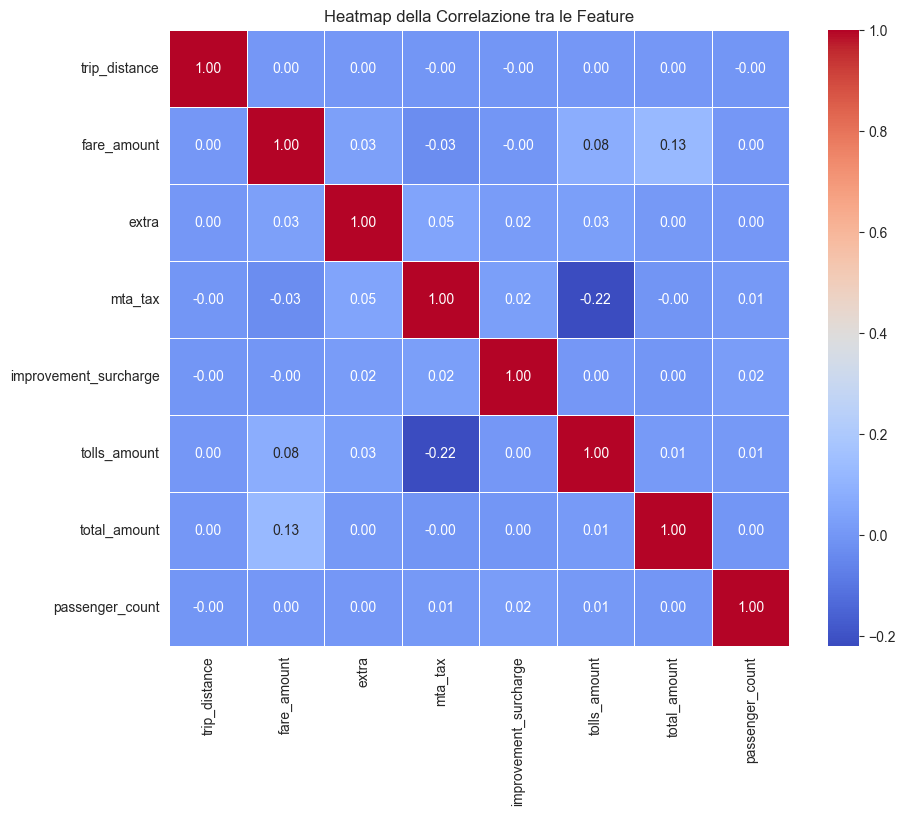

In [13]:
# Eliminazione di tip_amount dalla colonne da tenere in considerazione
# In quanto la feature genera due alti livelli di correlazione

new_numeric_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
]

new_numeric_df_normalized = numeric_df_normalized[new_numeric_columns]

# Calcola la matrice di correlazione
correlation_matrix = new_numeric_df_normalized.corr()

# Imposta la dimensione della figura
plt.figure(figsize=(10, 8))

# Crea la heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Aggiungi titolo e mostra la heatmap
plt.title("Heatmap della Correlazione tra le Feature")
plt.show()

In [14]:
from tabulate import tabulate

final_columns = [
    "trip_distance",         # Distanza del viaggio
    "fare_amount",           # Importo della tariffa
    "extra",                 # Extra e sovrapprezzi
    "mta_tax",               # Tassa MTA
    "improvement_surcharge", # Sovrapprezzo di miglioramento
    "tolls_amount",          # Importo totale dei pedaggi
    "total_amount",          # Importo totale addebitato
    "passenger_count",       # Numero di passeggeri
    "payment_type_creditCard", # Tipo di pagamento
    "pickup_period_notte", # Momento della corsa
]

# Mantieni solo le colonne specificate in final_columns
df_normalized = df_normalized[final_columns]
# print (df_normalized)
print(tabulate(df_normalized.head(10), headers="keys", tablefmt="psql"))

+----+-----------------+---------------+-----------+-----------+-------------------------+----------------+----------------+-------------------+---------------------------+-----------------------+
|    |   trip_distance |   fare_amount |     extra |   mta_tax |   improvement_surcharge |   tolls_amount |   total_amount |   passenger_count |   payment_type_creditCard |   pickup_period_notte |
|----+-----------------+---------------+-----------+-----------+-------------------------+----------------+----------------+-------------------+---------------------------+-----------------------|
|  0 |        0.150939 |    0.00107455 | 0.0741434 |  0.016538 |                       1 |     0.00854648 |    0.000118285 |          0.111111 |                         1 |                     1 |
|  1 |        0.15094  |    0.00108037 | 0.07368   |  0.016538 |                       1 |     0.00854648 |    0.000118474 |          0.111111 |                         1 |                     1 |
|  2 |        0

# Outlier Identification and Elimination

In [15]:
outliers_dict = {}

# Itera su tutte le colonne numeriche
for col in df_normalized.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df_normalized[col].quantile(0.25)
    Q3 = df_normalized[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = Q1 - 1.5 * IQR
    upper_limit = Q3 + 1.5 * IQR
    
    # Trova gli outlier per questa colonna
    outliers = df_normalized[(df_normalized[col] < lower_limit) | (df_normalized[col] > upper_limit)]
    outliers_dict[col] = outliers.index.tolist()  # Salva gli indici degli outlier
    
    print(f"Colonna: {col}, Numero di outlier: {len(outliers)}")

all_outliers = set([idx for indices in outliers_dict.values() for idx in indices])
print(f"Numero totale di outlier: {len(all_outliers)}")

Colonna: trip_distance, Numero di outlier: 4830459
Colonna: fare_amount, Numero di outlier: 4041047
Colonna: extra, Numero di outlier: 83787
Colonna: mta_tax, Numero di outlier: 175096
Colonna: improvement_surcharge, Numero di outlier: 717446
Colonna: tolls_amount, Numero di outlier: 2257948
Colonna: total_amount, Numero di outlier: 4062738
Colonna: passenger_count, Numero di outlier: 5064276
Colonna: payment_type_creditCard, Numero di outlier: 0
Colonna: pickup_period_notte, Numero di outlier: 0
Numero totale di outlier: 10355128


In [16]:
# Trova tutti gli indici univoci degli outlier
all_outliers = set([idx for indices in outliers_dict.values() for idx in indices])

print(f"Numero di righe originali: {len(df_normalized)}")

# Elimina le righe con questi indici dal DataFrame
df_normalized = df_normalized.drop(index=all_outliers)

print(f"Numero di righe dopo la rimozione degli outlier: {len(df_normalized)}")


Numero di righe originali: 47028697
Numero di righe dopo la rimozione degli outlier: 36673569


# PCA (solo SVM)

In [17]:
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, StratifiedKFold
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Separiamo le feature (X) dal target (y)
X = df_normalized.drop(columns='payment_type_creditCard')
y = df_normalized['payment_type_creditCard']

# Applica il sottocampionamento con RandomUnderSampler
undersampler = RandomUnderSampler(
    sampling_strategy={0: 20000, 1: 20000},  # 20k campioni per classe
    random_state=42
)

X_under, y_under = undersampler.fit_resample(X, y)

# Stampa la nuova distribuzione delle classi
print("Numero di campioni per ciascuna classe dopo il sottocampionamento:")
print(Counter(y_under))

# Suddividi il dataset bilanciato in training e test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_under, y_under, test_size=0.2, random_state=42, stratify=y_under
)

# PCA: Applica la PCA solo al training set (feature)
pca = PCA(n_components='mle', random_state=42)
X_train_pca = pca.fit_transform(X_train_val)

# Trasforma anche il test set usando la PCA calcolata sul training
X_test_pca = pca.transform(X_test)

# Ottieni i carichi (loadings) della PCA
loadings = pd.DataFrame(
    pca.components_.T,
    index=X_train_val.columns,  # Usa solo le colonne delle feature
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

# Identifica la feature dominante per ciascun componente principale
dominant_features = loadings.abs().idxmax(axis=0)

# Creiamo DataFrame dei componenti principali
X_train_pca_df = pd.DataFrame(X_train_pca, columns=dominant_features.values[:X_train_pca.shape[1]])
X_test_pca_df = pd.DataFrame(X_test_pca, columns=dominant_features.values[:X_test_pca.shape[1]])

# Reintegra il target per i plot e la valutazione
X_train_pca_df['payment_type_creditCard'] = y_train_val.values
X_test_pca_df['payment_type_creditCard'] = y_test.values

# Stampa la distribuzione finale nel training e test set
print("Distribuzione classi nel training set:")
print(Counter(y_train_val))
print("Distribuzione classi nel test set:")
print(Counter(y_test))


Numero di campioni per ciascuna classe dopo il sottocampionamento:
Counter({0: 20000, 1: 20000})
Distribuzione classi nel training set:
Counter({0: 16000, 1: 16000})
Distribuzione classi nel test set:
Counter({1: 4000, 0: 4000})


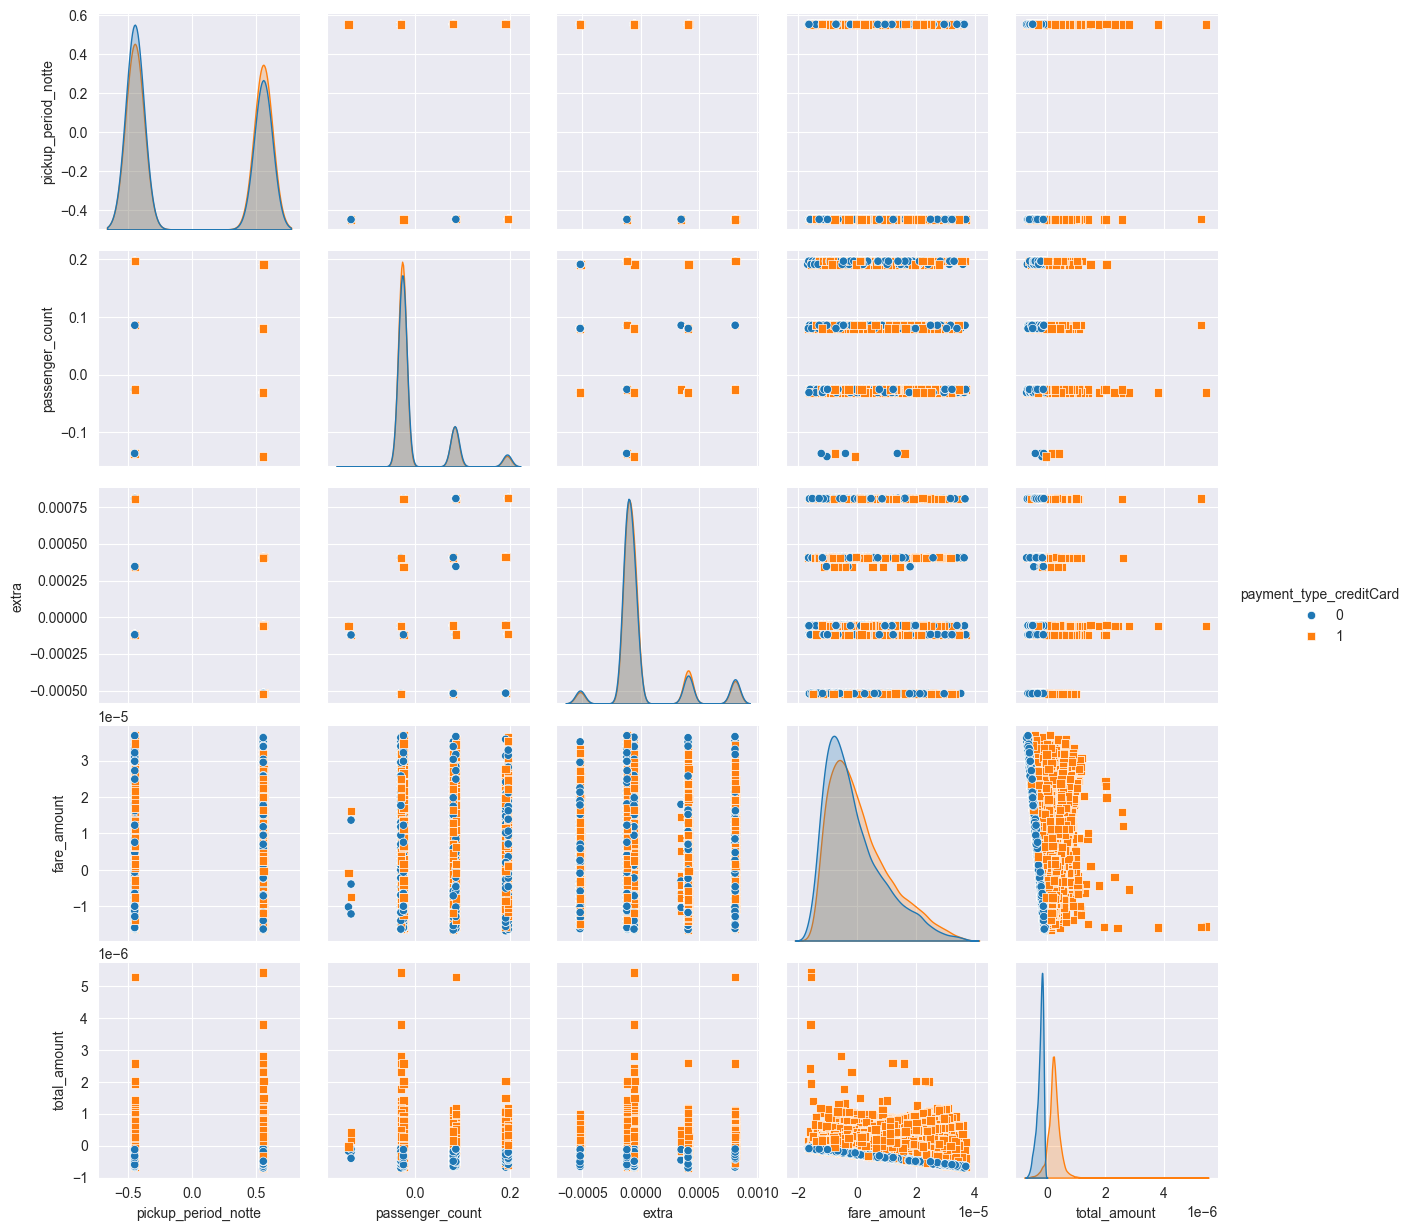

Fold 1:
- Training samples: 28800
- Validation samples: 3200
Fold 2:
- Training samples: 28800
- Validation samples: 3200
Fold 3:
- Training samples: 28800
- Validation samples: 3200
Fold 4:
- Training samples: 28800
- Validation samples: 3200
Fold 5:
- Training samples: 28800
- Validation samples: 3200
Fold 6:
- Training samples: 28800
- Validation samples: 3200
Fold 7:
- Training samples: 28800
- Validation samples: 3200
Fold 8:
- Training samples: 28800
- Validation samples: 3200
Fold 9:
- Training samples: 28800
- Validation samples: 3200
Fold 10:
- Training samples: 28800
- Validation samples: 3200


In [18]:
# Verifica della separabilità: Pair plot sul training set
sns.pairplot(X_train_pca_df, hue="payment_type_creditCard", diag_kind="kde", markers=["o", "s"])
plt.show()

# K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_pca, y_train_val)):
    print(f"Fold {fold+1}:")
    print(f"- Training samples: {len(train_idx)}")
    print(f"- Validation samples: {len(val_idx)}")

# Balancing and reducing the dataset

In [17]:
# Dato che esistono molti più casi in cui viene utilizzata la carta di credito come metodo di pagamento,
# applichiamo undersampling

from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Separiamo le feature (X) dal target (y)
# payment_type_creditCard rappresenta l'attributo delle classi (0 e 1)
X = df_normalized.drop(columns='payment_type_creditCard')
y = df_normalized['payment_type_creditCard']

# Inizializza il RandomUnderSampler con sampling_strategy
# Specifica il numero massimo di campioni per ciascuna classe
undersampler = RandomUnderSampler(
    sampling_strategy={0: 50000, 1: 50000},  # 50.000 campioni per classe
    random_state=42
)

# Per DecisionTree, RandomForest, Logistic Regression, KNN utilizzare 50k campioni per classe
# Per AdaBoostClassifier, SVM utilizzare 10k campioni per classe

# Applica il sottocampionamento
X_under, y_under = undersampler.fit_resample(X, y)

# Stampa la nuova distribuzione delle classi
print("Numero di campioni per ciascuna classe dopo il sottocampionamento:")
print(Counter(y_under))


Numero di campioni per ciascuna classe dopo il sottocampionamento:
Counter({0: 50000, 1: 50000})


# Divisione tra training set e test set (K-fold cross validation)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Utilizza il dataset bilanciato ottenuto dal primo blocco
X = X_under  # Dataset bilanciato delle feature
y = y_under  # Dataset bilanciato del target

# Holdout per dividere tra training e test set separato
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# Applicazione della k-fold cross validation sul training set
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


# Decision Tree Classifier

Fold 1/10
Accuratezza sul training set (fold 1): 0.9364
Accuratezza sul test set (fold 1): 0.9245
Fold 2/10
Accuratezza sul training set (fold 2): 0.9181
Accuratezza sul test set (fold 2): 0.9150
Fold 3/10
Accuratezza sul training set (fold 3): 0.9204
Accuratezza sul test set (fold 3): 0.9125
Fold 4/10
Accuratezza sul training set (fold 4): 0.9252
Accuratezza sul test set (fold 4): 0.9190
Fold 5/10
Accuratezza sul training set (fold 5): 0.9227
Accuratezza sul test set (fold 5): 0.9125
Fold 6/10
Accuratezza sul training set (fold 6): 0.9227
Accuratezza sul test set (fold 6): 0.9100
Fold 7/10
Accuratezza sul training set (fold 7): 0.9234
Accuratezza sul test set (fold 7): 0.9105
Fold 8/10
Accuratezza sul training set (fold 8): 0.9194
Accuratezza sul test set (fold 8): 0.9005
Fold 9/10
Accuratezza sul training set (fold 9): 0.9182
Accuratezza sul test set (fold 9): 0.9135
Fold 10/10
Accuratezza sul training set (fold 10): 0.9291
Accuratezza sul test set (fold 10): 0.9180

Risultati Finali

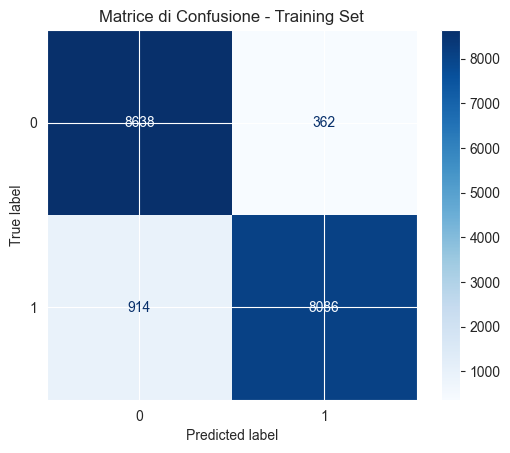

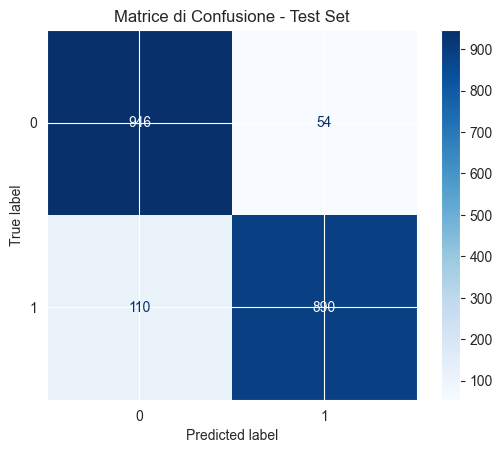

In [58]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_decision_tree_model.pkl"
    joblib.dump(model, filename)

# Inizializza il modello Decision Tree Classifier
model = DecisionTreeClassifier(
    criterion="gini",         # Funzione per misurare la qualità dello split ("gini" o "entropy")
    max_depth=None,           # Profondità massima dell'albero (None = nessun limite)
    min_samples_split=50,     # Minimo numero di campioni per suddividere un nodo
    random_state=42           
)

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_decision_tree"
os.makedirs(checkpoint_dir, exist_ok=True)

# Liste per memorizzare i punteggi di ciascun fold
train_fold_scores = []  # Accuratezza sul training set per ogni fold
test_fold_scores = []   # Accuratezza sul test set per ogni fold
best_accuracy = 0       # Per tenere traccia del miglior punteggio sul test set
best_model = None       # Per salvare il miglior modello

# Iterazione manuale per ciascun fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):  # Usa y per mantenere le proporzioni
    print(f"Fold {fold}/{kf.get_n_splits()}")
    
    # Suddividi il dataset in training e test per il fold corrente
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Addestra il modello sul training set
    model.fit(X_train, y_train)
    
    # Accuratezza sul training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_fold_scores.append(train_accuracy)
    print(f"Accuratezza sul training set (fold {fold}): {train_accuracy:.4f}")
    
    # Accuratezza sul test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_fold_scores.append(test_accuracy)
    print(f"Accuratezza sul test set (fold {fold}): {test_accuracy:.4f}")
    
    # Salva il modello se ha la miglior accuratezza sul test set finora
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        save_best_checkpoint(best_model)

# Calcola e stampa la media dei punteggi di tutti i fold
mean_train_accuracy = sum(train_fold_scores) / len(train_fold_scores)
mean_test_accuracy = sum(test_fold_scores) / len(test_fold_scores)

print("\nRisultati Finali:")
print(f"Accuratezza media sul training set: {mean_train_accuracy:.4f}")
print(f"Accuratezza media sul test set: {mean_test_accuracy:.4f}")

# Matrice di confusione sul training set per il miglior modello
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


Train Accuracy (media dei fold): 0.8829
Validation Accuracy (media dei fold): 0.8811

Test Set Accuracy: 0.8794

Valutazione sul test set:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89     10000
           1       0.95      0.80      0.87     10000

    accuracy                           0.88     20000
   macro avg       0.89      0.88      0.88     20000
weighted avg       0.89      0.88      0.88     20000



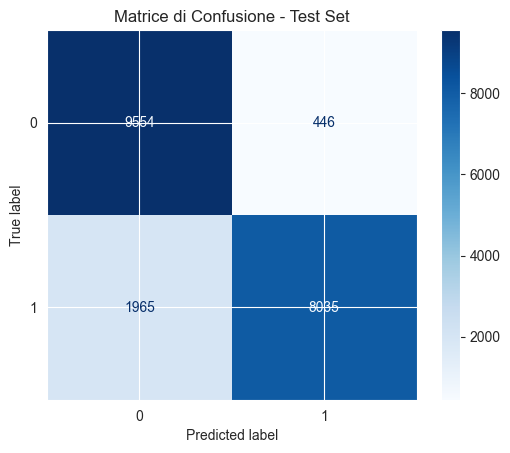

In [62]:
# Combinazione holdout e k-fold cross validation

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

train_accuracies = []
val_accuracies = []

# Itera sui fold
for train_index, val_index in kf.split(X_train_val, y_train_val):
    
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    # Inizializza il modello
    model = DecisionTreeClassifier(
        criterion="gini",
        max_depth=None,
        min_samples_split=50,
        random_state=42
    )

    # Addestra il modello
    model.fit(X_train, y_train)

    # Calcola l'accuratezza
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Media delle accuratezze
print(f"Train Accuracy (media dei fold): {np.mean(train_accuracies):.4f}")
print(f"Validation Accuracy (media dei fold): {np.mean(val_accuracies):.4f}")

# Addestra il modello finale su tutto il training set
final_model = DecisionTreeClassifier(
    criterion="gini",
    max_depth=None,
    min_samples_split=50,
    random_state=42
)
final_model.fit(X_train_val, y_train_val)

# Valutazione sul test set
y_test_pred = final_model.predict(X_test)
# Necessario per la curva ROC
y_test_pred_proba = final_model.predict_proba(X_test)  # Probabilità previste

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

print("\nValutazione sul test set:")
print(classification_report(y_test, y_test_pred))

# Matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=final_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


# Curva ROC Decision Tree

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcola le probabilità previste per la classe positiva
if hasattr(best_model, "predict_proba"):
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilità per la classe positiva
else:
    raise AttributeError("Il modello non supporta predict_proba, necessario per la curva ROC.")

# Calcola FPR, TPR e soglie per la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcola l'AUC (Area Under Curve)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Disegna la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=1.5)  # Linea diagonale
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.title("Curva ROC del Miglior Modello", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

NameError: name 'best_model' is not defined

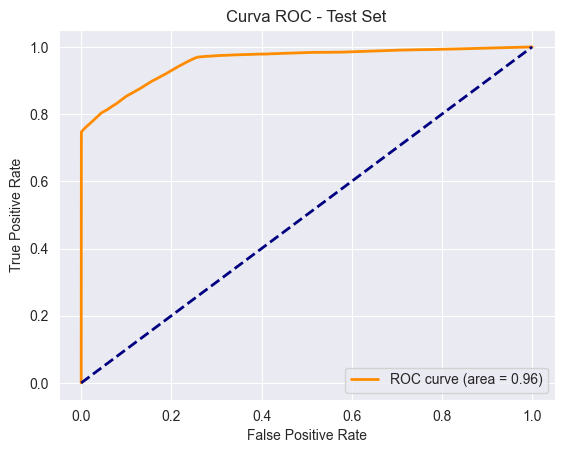

In [63]:
# Curva ROC con combinazione holdout e k-fold

# Calcolo della curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:, 1])  # Probabilità della classe positiva
roc_auc = auc(fpr, tpr)

# Visualizzazione della curva ROC
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Test Set")
plt.legend(loc="lower right")
plt.show()

# Random Forest Classifier

Fold 1/10
Accuratezza sul training set (fold 1): 0.9132
Accuratezza sul test set (fold 1): 0.9083
Fold 2/10
Accuratezza sul training set (fold 2): 0.9268
Accuratezza sul test set (fold 2): 0.9248
Fold 3/10
Accuratezza sul training set (fold 3): 0.9273
Accuratezza sul test set (fold 3): 0.9221
Fold 4/10
Accuratezza sul training set (fold 4): 0.9315
Accuratezza sul test set (fold 4): 0.9233
Fold 5/10
Accuratezza sul training set (fold 5): 0.9162
Accuratezza sul test set (fold 5): 0.9079
Fold 6/10
Accuratezza sul training set (fold 6): 0.9233
Accuratezza sul test set (fold 6): 0.9167
Fold 7/10
Accuratezza sul training set (fold 7): 0.9041
Accuratezza sul test set (fold 7): 0.8980
Fold 8/10
Accuratezza sul training set (fold 8): 0.9064
Accuratezza sul test set (fold 8): 0.8998
Fold 9/10
Accuratezza sul training set (fold 9): 0.9093
Accuratezza sul test set (fold 9): 0.9019
Fold 10/10
Accuratezza sul training set (fold 10): 0.9167
Accuratezza sul test set (fold 10): 0.9133

Risultati Finali

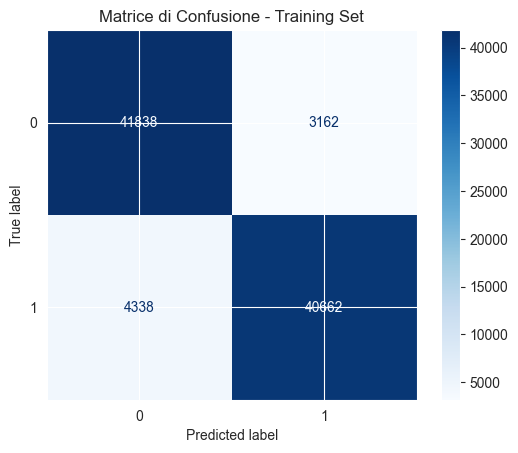

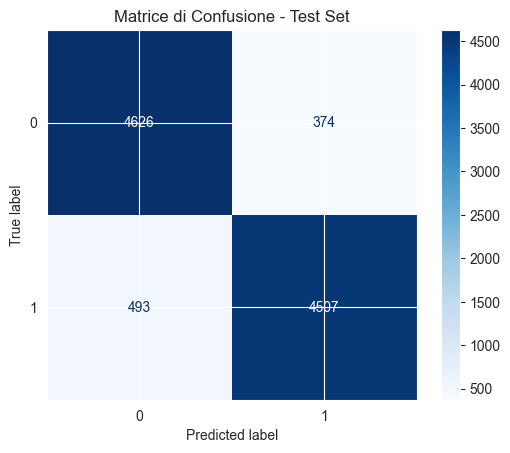

In [38]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_random_forest_model.pkl"
    joblib.dump(model, filename)

# Inizializza il modello
model = RandomForestClassifier(
    n_estimators=100,       # Numero di alberi
    max_depth=None,         # Profondità massima degli alberi
    min_samples_split=50,   # Minimo numero di campioni per suddividere un nodo
    random_state=42         
)

# Cartella per salvare i checkpoint
checkpoint_dir = "best_checkpoint_random_forest"
os.makedirs(checkpoint_dir, exist_ok=True)

# Configura Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Liste per memorizzare i punteggi di ciascun fold
train_fold_scores = []  # Accuratezza sul training set per ogni fold
test_fold_scores = []   # Accuratezza sul test set per ogni fold
best_accuracy = 0       # Per tenere traccia del miglior punteggio sul test set
best_model = None       # Per salvare il miglior modello

# Iterazione manuale per ciascun fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):  
    print(f"Fold {fold}/{kf.get_n_splits()}")

    # Suddividi il dataset in training e test per il fold corrente
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestra il modello sul training set
    model.fit(X_train, y_train)

    # Accuratezza sul training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_fold_scores.append(train_accuracy)
    print(f"Accuratezza sul training set (fold {fold}): {train_accuracy:.4f}")

    # Accuratezza sul test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_fold_scores.append(test_accuracy)
    print(f"Accuratezza sul test set (fold {fold}): {test_accuracy:.4f}")

    # Salva il modello se ha la miglior accuratezza sul test set finora
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        save_best_checkpoint(best_model)

# Calcola e stampa la media dei punteggi di tutti i fold
mean_train_accuracy = sum(train_fold_scores) / len(train_fold_scores)
mean_test_accuracy = sum(test_fold_scores) / len(test_fold_scores)

print("\nRisultati Finali:")
print(f"Accuratezza media sul training set: {mean_train_accuracy:.4f}")
print(f"Accuratezza media sul test set: {mean_test_accuracy:.4f}")

# Matrice di confusione sul training set per il miglior modello
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()

Train Accuracy (media dei fold): 0.8367
Validation Accuracy (media dei fold): 0.8348

Test Set Accuracy: 0.8300

Report di classificazione - Test Set:
              precision    recall  f1-score   support

           0       0.89      0.75      0.82     10000
           1       0.79      0.91      0.84     10000

    accuracy                           0.83     20000
   macro avg       0.84      0.83      0.83     20000
weighted avg       0.84      0.83      0.83     20000



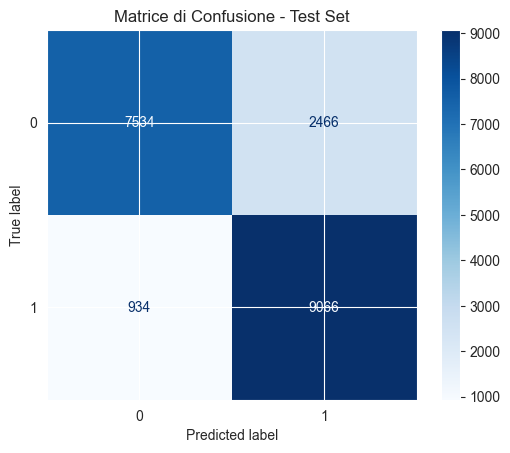

In [137]:
# Combinazione holdout e k-fold cross validation

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt

train_accuracies = []
val_accuracies = []

# Itera sui fold
for train_index, val_index in kf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    # Inizializza il modello Random Forest
    model = RandomForestClassifier(
        n_estimators=100,           # Numero di alberi nella foresta
        max_depth=None,             # Profondità massima (None = nessun limite)
        min_samples_split=50,       # Minimo numero di campioni per dividere un nodo
        random_state=42,            # Per riproducibilità
        n_jobs=-1                   # Utilizza tutti i core disponibili
    )

    # Addestra il modello
    model.fit(X_train, y_train)

    # Calcola l'accuratezza
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Media delle accuratezze
print(f"Train Accuracy (media dei fold): {np.mean(train_accuracies):.4f}")
print(f"Validation Accuracy (media dei fold): {np.mean(val_accuracies):.4f}")

# Addestra il modello finale su tutto il training set
final_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=50,
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train_val, y_train_val)

# Valutazione sul test set
y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)  # Probabilità previste

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

print("\nReport di classificazione - Test Set:")
print(classification_report(y_test, y_test_pred))

# Matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=final_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()

# Curva ROC Random Forest

In [112]:
# Calcola le probabilità previste per la classe positiva
if hasattr(best_model, "predict_proba"):
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilità per la classe positiva
else:
    raise AttributeError("Il modello non supporta predict_proba, necessario per la curva ROC.")

# Calcola FPR, TPR e soglie per la curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Calcola l'AUC (Area Under Curve)
roc_auc = roc_auc_score(y_test, y_pred_prob)

# Disegna la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], color="gray", linestyle="--", linewidth=1.5)  # Linea diagonale
plt.xlabel("False Positive Rate (FPR)", fontsize=12)
plt.ylabel("True Positive Rate (TPR)", fontsize=12)
plt.title("Curva ROC del Miglior Modello Random Forest", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

NameError: name 'roc_auc_score' is not defined

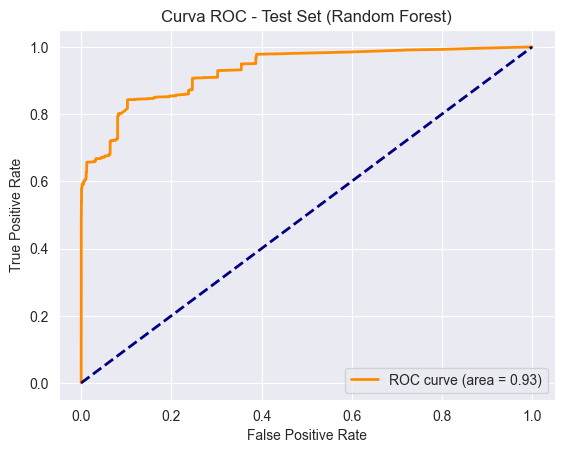

In [138]:
# Calcolo della curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:, 1])  # Probabilità della classe positiva
roc_auc = auc(fpr, tpr)

# Visualizzazione della curva ROC
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Test Set (Random Forest)")
plt.legend(loc="lower right")
plt.show()

# Logistic Regression

Fold 1/10
Accuratezza sul training set (fold 1): 0.5236
Accuratezza sul test set (fold 1): 0.5231
Fold 2/10
Accuratezza sul training set (fold 2): 0.5231
Accuratezza sul test set (fold 2): 0.5276
Fold 3/10
Accuratezza sul training set (fold 3): 0.5241
Accuratezza sul test set (fold 3): 0.5182
Fold 4/10
Accuratezza sul training set (fold 4): 0.5234
Accuratezza sul test set (fold 4): 0.5248
Fold 5/10
Accuratezza sul training set (fold 5): 0.5239
Accuratezza sul test set (fold 5): 0.5203
Fold 6/10
Accuratezza sul training set (fold 6): 0.5232
Accuratezza sul test set (fold 6): 0.5264
Fold 7/10
Accuratezza sul training set (fold 7): 0.5231
Accuratezza sul test set (fold 7): 0.5273
Fold 8/10
Accuratezza sul training set (fold 8): 0.5241
Accuratezza sul test set (fold 8): 0.5180
Fold 9/10
Accuratezza sul training set (fold 9): 0.5235
Accuratezza sul test set (fold 9): 0.5241
Fold 10/10
Accuratezza sul training set (fold 10): 0.5233
Accuratezza sul test set (fold 10): 0.5254

Risultati Finali

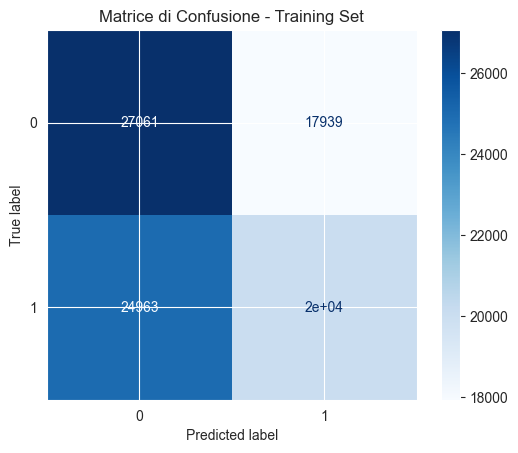

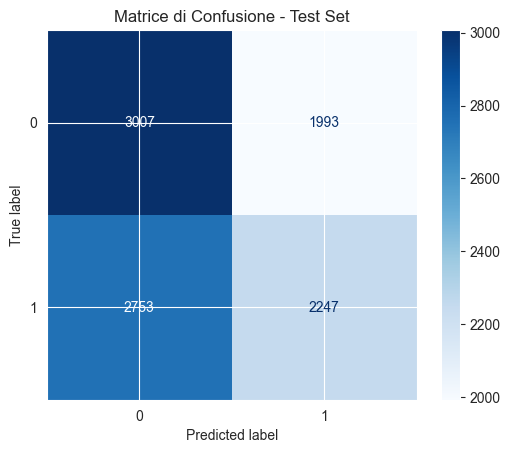

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_logistic_regression_model.pkl"
    joblib.dump(model, filename)

# Inizializza il modello Logistic Regression
model = LogisticRegression(
    penalty='elasticnet',          # Regolarizzazione L2
    C= 0.1,                 # Inverso della forza di regolarizzazione
    solver='saga',        # Solutore per problemi grandi
    l1_ratio=0.5,
    max_iter=1000,         # Iterazioni massime
    random_state=42        # Per riproducibilità
)

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_logistic_regression"
os.makedirs(checkpoint_dir, exist_ok=True)

# Liste per memorizzare i punteggi di ciascun fold
train_fold_scores = []  # Accuratezza sul training set per ogni fold
test_fold_scores = []   # Accuratezza sul test set per ogni fold
best_accuracy = 0       # Per tenere traccia del miglior punteggio sul test set
best_model = None       # Per salvare il miglior modello

# Iterazione manuale per ciascun fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    print(f"Fold {fold}/{kf.get_n_splits()}")

    # Suddividi il dataset in training e test per il fold corrente
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestra il modello sul training set
    model.fit(X_train, y_train)

    # Accuratezza sul training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_fold_scores.append(train_accuracy)
    print(f"Accuratezza sul training set (fold {fold}): {train_accuracy:.4f}")

    # Accuratezza sul test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_fold_scores.append(test_accuracy)
    print(f"Accuratezza sul test set (fold {fold}): {test_accuracy:.4f}")

    # Salva il modello se ha la miglior accuratezza sul test set finora
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        save_best_checkpoint(best_model)

# Calcola e stampa la media dei punteggi di tutti i fold
mean_train_accuracy = sum(train_fold_scores) / len(train_fold_scores)
mean_test_accuracy = sum(test_fold_scores) / len(test_fold_scores)

print("\nRisultati Finali:")
print(f"Accuratezza media sul training set: {mean_train_accuracy:.4f}")
print(f"Accuratezza media sul test set: {mean_test_accuracy:.4f}")

# Matrice di confusione sul training set per il miglior modello
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


Train Accuracy (media dei fold): 0.5233
Validation Accuracy (media dei fold): 0.5233

Test Set Accuracy: 0.5196

Report di classificazione - Test Set:
              precision    recall  f1-score   support

           0       0.52      0.59      0.55      6000
           1       0.52      0.45      0.48      6000

    accuracy                           0.52     12000
   macro avg       0.52      0.52      0.52     12000
weighted avg       0.52      0.52      0.52     12000



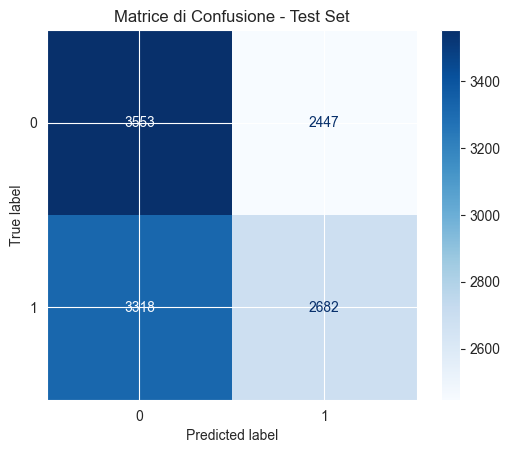

In [19]:
# Combinazione holdout e k-fold cross validation

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt

train_accuracies = []
val_accuracies = []

# Itera sui fold
for train_index, val_index in kf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    # Inizializza il modello Logistic Regression
    model = LogisticRegression(
        penalty='elasticnet',          # ElasticNet combina L1 (Lasso) e L2 (Ridge)
        l1_ratio=0.5,                  # Peso tra L1 e L2 (0 = solo L2, 1 = solo L1)
        C=1.0,                         # Regolarizzazione complessiva (più basso = più forte)
        solver='saga',                 # Solver necessario per ElasticNet
        max_iter=1000,                 # Iterazioni massime
        random_state=42,               # Riproducibilità
        n_jobs=-1                      # Utilizza tutti i core disponibili
    )


    # Addestra il modello
    model.fit(X_train, y_train)

    # Calcola l'accuratezza
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Media delle accuratezze
print(f"Train Accuracy (media dei fold): {np.mean(train_accuracies):.4f}")
print(f"Validation Accuracy (media dei fold): {np.mean(val_accuracies):.4f}")

# Addestra il modello finale su tutto il training set
final_model = LogisticRegression(
    penalty='elasticnet',          # ElasticNet combina L1 (Lasso) e L2 (Ridge)
    l1_ratio=0.5,                  # Peso tra L1 e L2 (0 = solo L2, 1 = solo L1)
    C=1.0,                         # Regolarizzazione complessiva (più basso = più forte)
    solver='saga',                 # Solver necessario per ElasticNet
    max_iter=1000,                 # Iterazioni massime
    random_state=42,               # Riproducibilità
    n_jobs=-1                      # Utilizza tutti i core disponibili
)

final_model.fit(X_train_val, y_train_val)

# Valutazione sul test set
y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)  # Probabilità previste

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

print("\nReport di classificazione - Test Set:")
print(classification_report(y_test, y_test_pred))

# Matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=final_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()

# Curva ROC per Logistic Regression

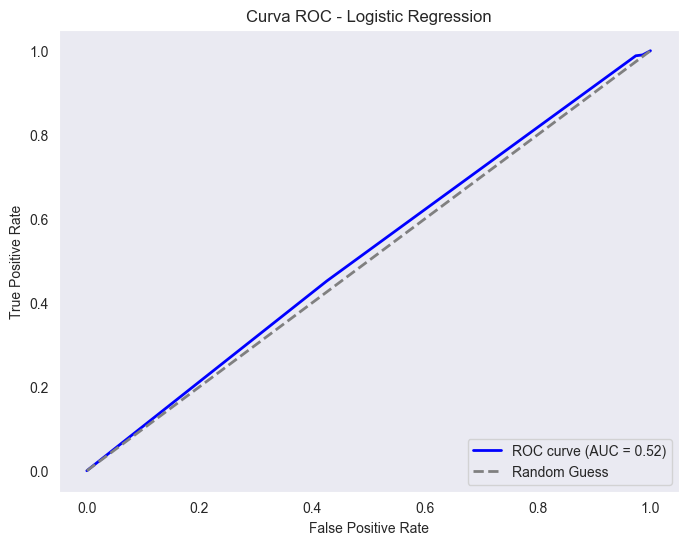

In [43]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
import matplotlib.pyplot as plt

# Calcola le probabilità predette per la classe positiva (1)
y_pred_proba = model.predict_proba(X_test)[:, 1]  # Probabilità per la classe positiva

# Calcola i valori FPR (False Positive Rate), TPR (True Positive Rate) e le soglie
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcola l'AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)

# Visualizza la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Logistic Regression')
plt.legend(loc='lower right')
plt.grid()
plt.show()

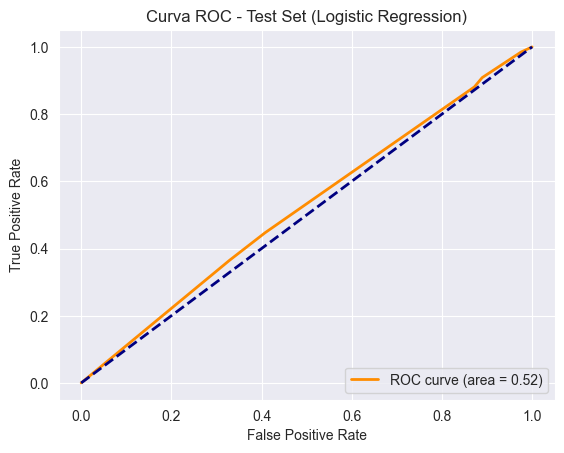

In [20]:
# Combinazione holdout e k-fold cross validation

# Calcolo della curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:, 1])  # Probabilità della classe positiva
roc_auc = auc(fpr, tpr)

# Visualizzazione della curva ROC
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Test Set (Logistic Regression)")
plt.legend(loc="lower right")
plt.show()

# SVM

Train Accuracy (media dei fold): 0.5244
Validation Accuracy (media dei fold): 0.5234

Test Set Accuracy: 0.5181

Report di classificazione - Test Set:
              precision    recall  f1-score   support

           0       0.52      0.57      0.54      4000
           1       0.52      0.47      0.49      4000

    accuracy                           0.52      8000
   macro avg       0.52      0.52      0.52      8000
weighted avg       0.52      0.52      0.52      8000



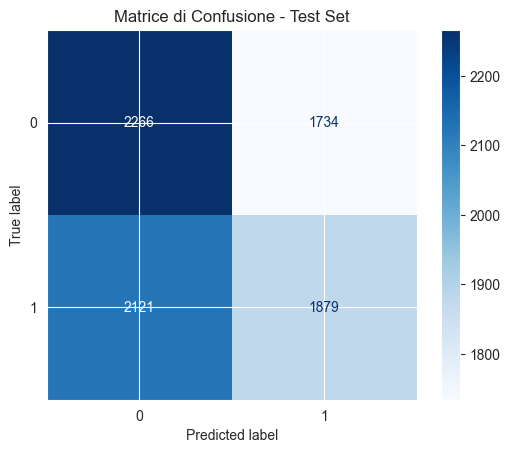

In [37]:
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import numpy as np
import matplotlib.pyplot as plt

# Trasforma X_train_val e X_test usando il PCA esistente
X_train_val_pca = pca.transform(X_train_val)  # Trasforma il training/validation set
X_test_pca = pca.transform(X_test)           # Trasforma il test set

# K-Fold Cross-Validation
train_accuracies = []
val_accuracies = []

for train_index, val_index in kf.split(X_train_val_pca, y_train_val):
    # Dividi i dati nei fold
    X_train = X_train_val_pca[train_index]
    X_val = X_train_val_pca[val_index]
    y_train = y_train_val.iloc[train_index]
    y_val = y_train_val.iloc[val_index]

    # Inizializza il modello SVM
    model = SVC(
        kernel='rbf',               # Kernel RBF (Gaussian)
        C=1.0,                      # Forza di regolarizzazione
        probability=True,           # Calcola probabilità (necessario per curva ROC)
        random_state=42
    )

    # Addestra il modello
    model.fit(X_train, y_train)

    # Calcola l'accuratezza
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Media delle accuratezze
print(f"Train Accuracy (media dei fold): {np.mean(train_accuracies):.4f}")
print(f"Validation Accuracy (media dei fold): {np.mean(val_accuracies):.4f}")

# Addestra il modello finale su tutto il training set
final_model = SVC(
    kernel='rbf',
    C=1.0,
    probability=True,
    random_state=42
)
final_model.fit(X_train_val_pca, y_train_val)

# Valutazione sul test set
assert X_test.shape[0] == y_test.shape[0], "Mismatch tra X_test e y_test"

# Predizioni sul test set
y_test_pred = final_model.predict(X_test_pca)
y_test_pred_proba = final_model.predict_proba(X_test_pca)

# Accuratezza sul test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

# Report di classificazione
print("\nReport di classificazione - Test Set:")
print(classification_report(y_test, y_test_pred))

# Matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=final_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()



** Inizio Cross-Validation **
Fold 1: Accuracy = 0.5141
Fold 2: Accuracy = 0.5184
Fold 3: Accuracy = 0.5247
Fold 4: Accuracy = 0.5244
Fold 5: Accuracy = 0.5212
Fold 6: Accuracy = 0.5341
Fold 7: Accuracy = 0.5216
Fold 8: Accuracy = 0.5262
Fold 9: Accuracy = 0.5178
Fold 10: Accuracy = 0.5316

** Risultati Cross-Validation **
Accuratezza media: 0.5234 ± 0.0058

** Risultati sul Test Set **
              precision    recall  f1-score   support

           0       0.52      0.57      0.54      4000
           1       0.52      0.47      0.49      4000

    accuracy                           0.52      8000
   macro avg       0.52      0.52      0.52      8000
weighted avg       0.52      0.52      0.52      8000

Accuratezza sul Test Set: 0.5181


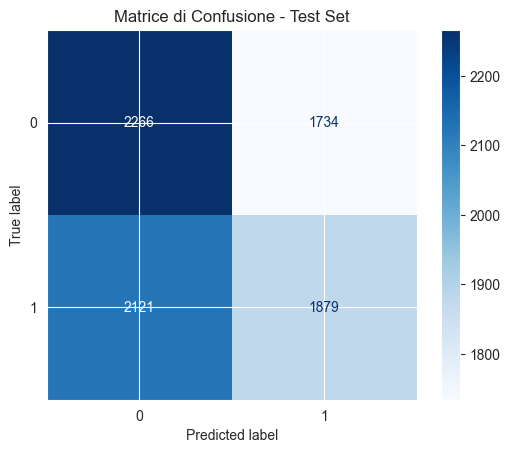

In [21]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
import numpy as np

# PCA e undersampling già eseguiti
# Dati: X_train_pca, X_test_pca, y_train_val, y_test

# Inizializza il modello SVM
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)  # Puoi modificare kernel, C e gamma per ottimizzare

# Valutazione con K-Fold Cross Validation sul training set
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_accuracies = []  # Per salvare le accuratezze di ogni fold

print("\n** Inizio Cross-Validation **")
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_pca, y_train_val)):
    X_train_fold, X_val_fold = X_train_pca[train_idx], X_train_pca[val_idx]
    y_train_fold, y_val_fold = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]
    
    # Addestra il modello
    svm_model.fit(X_train_fold, y_train_fold)
    
    # Valida il modello
    y_val_pred = svm_model.predict(X_val_fold)
    accuracy = accuracy_score(y_val_fold, y_val_pred)
    cv_accuracies.append(accuracy)
    print(f"Fold {fold+1}: Accuracy = {accuracy:.4f}")

print(f"\n** Risultati Cross-Validation **")
print(f"Accuratezza media: {np.mean(cv_accuracies):.4f} ± {np.std(cv_accuracies):.4f}")

# Addestramento finale sul training set completo
svm_model.fit(X_train_pca, y_train_val)

# Predizioni sul test set
y_test_pred = svm_model.predict(X_test_pca)

# Valutazione finale sul test set
print("\n** Risultati sul Test Set **")
print(classification_report(y_test, y_test_pred))
print(f"Accuratezza sul Test Set: {accuracy_score(y_test, y_test_pred):.4f}")

# Matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


# ROC curve SVM

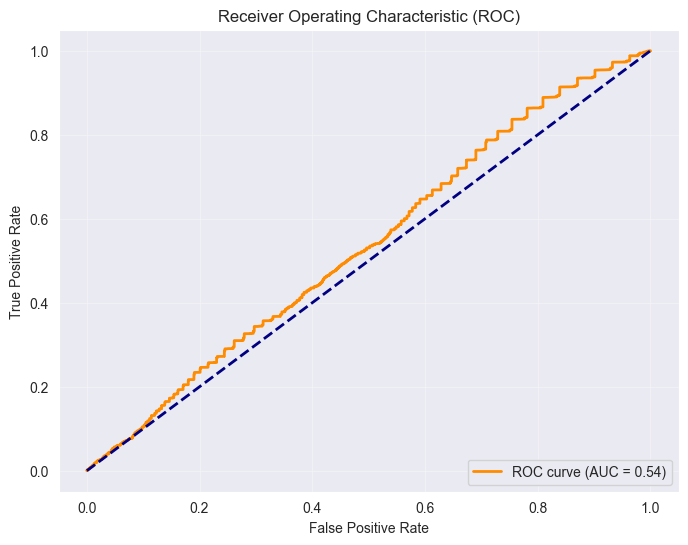

In [22]:
from sklearn.metrics import roc_curve, auc

# Calcolo e grafico della curva ROC
y_score = svm_model.decision_function(X_test_pca)  # Usa decision_function per ottenere i punteggi
fpr, tpr, thresholds = roc_curve(y_test, y_score)  # Calcola False Positive Rate e True Positive Rate
roc_auc = auc(fpr, tpr)  # Calcola l'area sotto la curva ROC

# Traccia la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linea casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# AdaBoostClassifier

In [58]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_adaboost_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_adaboost"
os.makedirs(checkpoint_dir, exist_ok=True)

# Configura Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Inizializza il modello AdaBoost con un classificatore base (Decision Tree)
base_estimator = DecisionTreeClassifier(max_depth=7)  # Stump decision tree
model = AdaBoostClassifier(
    estimator=base_estimator,
    algorithm="SAMME",
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

# Liste per memorizzare i punteggi di ciascun fold
train_fold_scores = []  # Accuratezza sul training set per ogni fold
test_fold_scores = []   # Accuratezza sul test set per ogni fold
best_accuracy = 0       # Per tenere traccia del miglior punteggio sul test set
best_model = None       # Per salvare il miglior modello

# Iterazione manuale per ciascun fold
for fold, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    print(f"Fold {fold}/{kf.get_n_splits()}")

    # Suddividi il dataset in training e test per il fold corrente
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Addestra il modello sul training set
    model.fit(X_train, y_train)

    # Accuratezza sul training set
    y_train_pred = model.predict(X_train)
    train_accuracy = accuracy_score(y_train, y_train_pred)
    train_fold_scores.append(train_accuracy)
    print(f"Accuratezza sul training set (fold {fold}): {train_accuracy:.4f}")

    # Accuratezza sul test set
    y_test_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_fold_scores.append(test_accuracy)
    print(f"Accuratezza sul test set (fold {fold}): {test_accuracy:.4f}")

    # Salva il modello se ha la miglior accuratezza sul test set finora
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = model
        save_best_checkpoint(best_model)

# Calcola e stampa la media dei punteggi di tutti i fold
final_mean_train_accuracy = sum(train_fold_scores) / len(train_fold_scores)
final_mean_test_accuracy = sum(test_fold_scores) / len(test_fold_scores)

print("\nRisultati Finali:")
print(f"Accuratezza media sul training set: {final_mean_train_accuracy:.4f}")
print(f"Accuratezza media sul test set: {final_mean_test_accuracy:.4f}")

# Matrice di confusione sul training set per il miglior modello
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


Fold 1/10
Accuratezza sul training set (fold 1): 0.8254
Accuratezza sul test set (fold 1): 0.8225
Miglior modello salvato: best_checkpoint_adaboost/best_adaboost_model.pkl
Fold 2/10


KeyboardInterrupt: 

Train Accuracy (media dei fold): 0.9492
Validation Accuracy (media dei fold): 0.9471

Test Set Accuracy: 0.9397

Report di classificazione - Test Set:
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2000
           1       0.99      0.89      0.94      2000

    accuracy                           0.94      4000
   macro avg       0.94      0.94      0.94      4000
weighted avg       0.94      0.94      0.94      4000



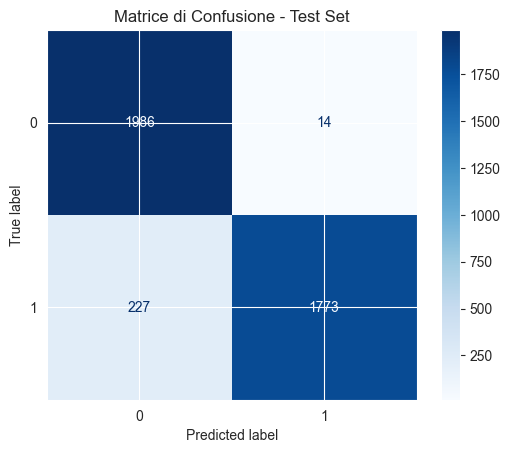

In [19]:
# Combinazione holdout e k-fold cross validation

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
)
from sklearn.model_selection import train_test_split, StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

train_accuracies = []
val_accuracies = []

# Itera sui fold
for train_index, val_index in kf.split(X_train_val, y_train_val):
    X_train, X_val = X_train_val.iloc[train_index], X_train_val.iloc[val_index]
    y_train, y_val = y_train_val.iloc[train_index], y_train_val.iloc[val_index]

    # Inizializza il modello AdaBoost
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=7),  # Stump decision tree come base learner
        algorithm="SAMME",
        n_estimators=50,                                    # Numero di stime
        learning_rate=1.0,                                  # Velocità di apprendimento
        random_state=42
    )

    # Addestra il modello
    model.fit(X_train, y_train)

    # Calcola l'accuratezza
    train_acc = accuracy_score(y_train, model.predict(X_train))
    val_acc = accuracy_score(y_val, model.predict(X_val))

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Media delle accuratezze
print(f"Train Accuracy (media dei fold): {np.mean(train_accuracies):.4f}")
print(f"Validation Accuracy (media dei fold): {np.mean(val_accuracies):.4f}")

# Addestra il modello finale su tutto il training set
final_model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=7),
    algorithm="SAMME",
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)
final_model.fit(X_train_val, y_train_val)

# Valutazione sul test set
y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)  # Probabilità previste

test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nTest Set Accuracy: {test_accuracy:.4f}")

print("\nReport di classificazione - Test Set:")
print(classification_report(y_test, y_test_pred))

# Matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=final_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


# Curva ROC AdaBoostClassifier

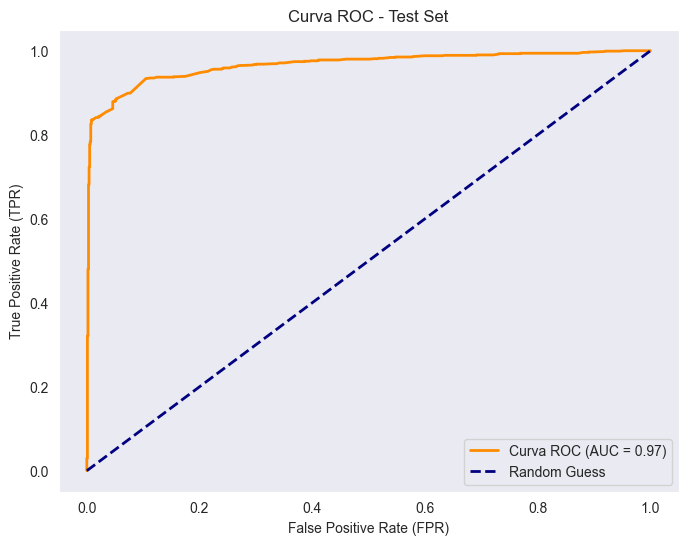

In [37]:
from sklearn.metrics import roc_curve, auc

# Calcolo e visualizzazione della curva ROC sul test set
y_test_prob = best_model.predict_proba(X_test)[:, 1]  # Probabilità per la classe positiva
fpr, tpr, thresholds = roc_curve(y_test, y_test_prob)  # Calcola FPR, TPR e soglie
roc_auc = auc(fpr, tpr)  # Calcola l'area sotto la curva (AUC)

# Tracciamento della curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"Curva ROC (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC - Test Set")
plt.legend(loc="lower right")
plt.grid()
plt.show()


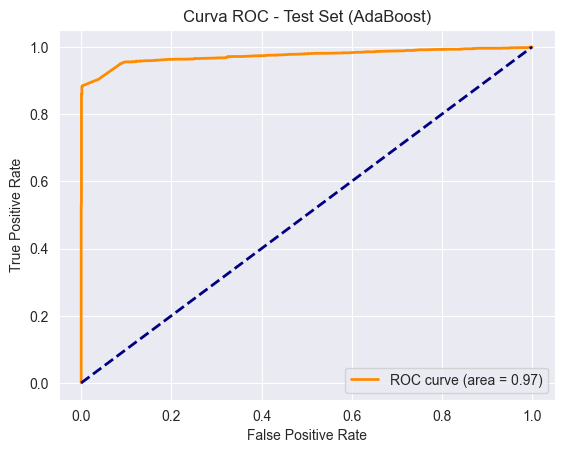

In [20]:
# Combinazione holdout e k-fold cross validation

# Calcolo della curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba[:, 1])  # Probabilità della classe positiva
roc_auc = auc(fpr, tpr)

# Visualizzazione della curva ROC
plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC - Test Set (AdaBoost)")
plt.legend(loc="lower right")
plt.show()

# KNN


Accuratezza sul Test Set Indipendente: 0.9771


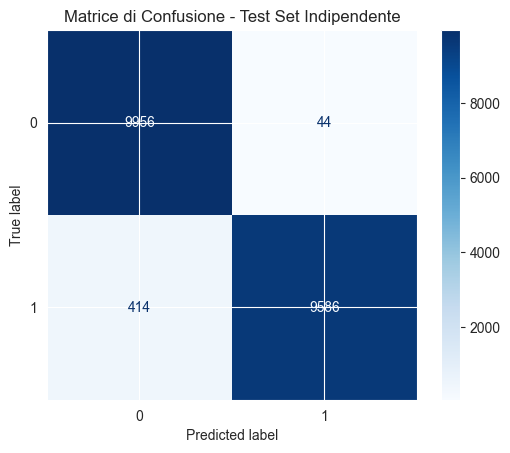


Classification Report:
              precision    recall  f1-score   support

    Classe 0       0.96      1.00      0.98     10000
    Classe 1       1.00      0.96      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt

# Inizializza il modello KNN con parametri predefiniti
knn_model = KNeighborsClassifier(
    n_neighbors=5,          # Numero di vicini da considerare (default = 5)
    weights="uniform",      # Uniforme (tutti i vicini hanno lo stesso peso)
    metric="minkowski",     # Distanza di Minkowski (default, equivalente a euclidea con p=2)
)

# Addestra il modello sul training set
knn_model.fit(X_train_val, y_train_val)

# Predizioni sul test set indipendente
y_test_pred = knn_model.predict(X_test)

# Calcola le probabilità sul test set
y_test_proba = knn_model.predict_proba(X_test)[:, 1]  # Probabilità della classe positiva (1)

# Calcola l'accuratezza sul test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAccuratezza sul Test Set Indipendente: {test_accuracy:.4f}")

# Calcola la matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)

# Visualizza la matrice di confusione
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=knn_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set Indipendente")
plt.show()

# Calcola e stampa il classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Classe 0", "Classe 1"]))


# Curva ROC KNN

AUC: 0.9830


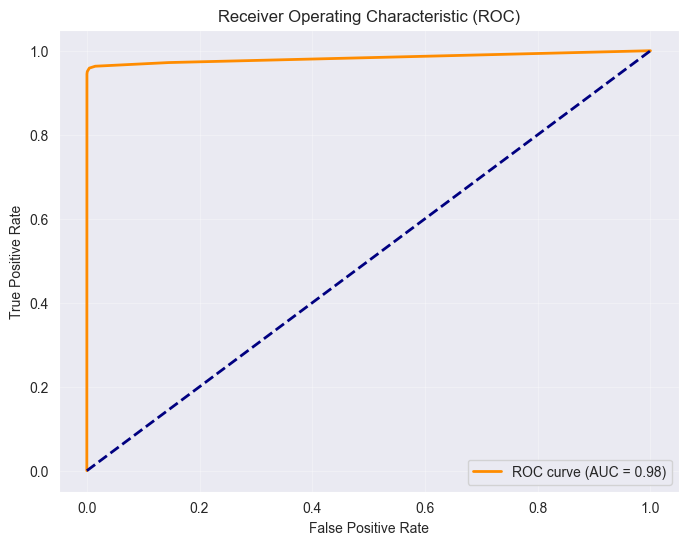

In [29]:
# Calcola FPR, TPR e soglie
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba)

# Calcola l'AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

# Traccia la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Linea casuale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Hyperparameter Ottimization: GridSearch()

# Decision Tree

Fitting 10 folds for each of 24 candidates, totalling 240 fits

Migliori parametri trovati:
{'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 10}
Accuratezza media del miglior modello: 0.8743
Miglior modello salvato: best_checkpoint_decision_tree/best_decision_tree_model.pkl


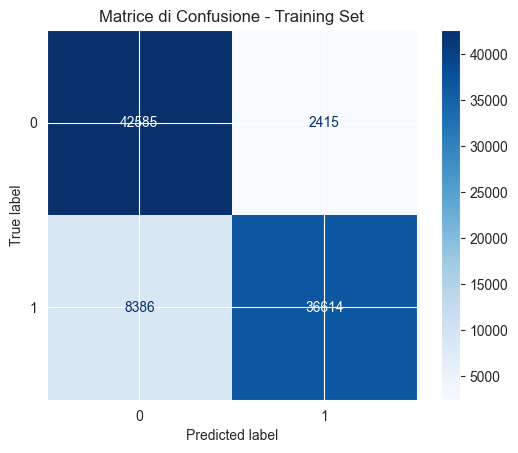

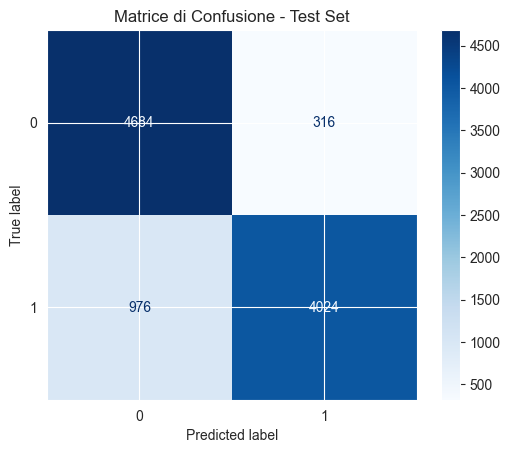

In [62]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_decision_tree_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_decision_tree"
os.makedirs(checkpoint_dir, exist_ok=True)

# Configura Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definizione dei parametri per il Grid Search
param_grid = {
    "criterion": ["gini", "entropy"],  # Funzione per misurare la qualità dello split
    "max_depth": [None, 10, 20, 30],  # Profondità massima dell'albero
    "min_samples_split": [10, 20, 50]  # Minimo numero di campioni per suddividere un nodo
}

# Inizializza il modello Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Configura il Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,                # Usa StratifiedKFold come validazione incrociata
    scoring="accuracy",   # Metrica da ottimizzare
    n_jobs=-1,            # Usa tutti i processori disponibili
    verbose=2             # Stampa il progresso
)

# Esegui il Grid Search con i dati bilanciati
grid_search.fit(X, y)

# Migliori parametri trovati
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Matrice di confusione sul training set per il miglior modello
train_index, test_index = next(iter(kf.split(X, y)))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

best_model.fit(X_train, y_train)
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()



Fitting 10 folds for each of 24 candidates, totalling 240 fits

Migliori parametri trovati:
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 10}
Miglior modello salvato: best_checkpoint_decision_tree/best_decision_tree_model.pkl

Accuratezza sul Test Set Indipendente: 0.8798


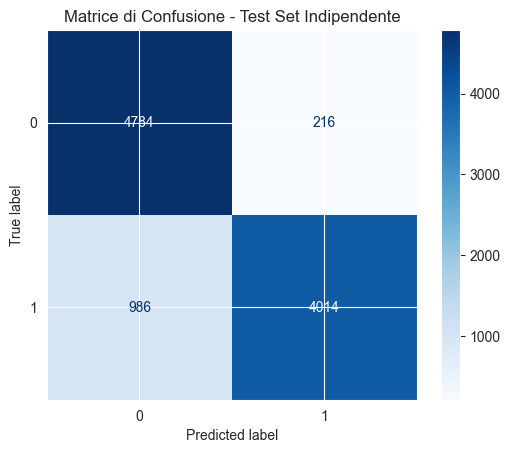

In [68]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_decision_tree_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_decision_tree"
os.makedirs(checkpoint_dir, exist_ok=True)

# Definizione dei parametri per il Grid Search
param_grid = {
    "criterion": ["gini", "entropy"],  # Funzione per misurare la qualità dello split
    "max_depth": [None, 10, 20, 30],  # Profondità massima dell'albero
    "min_samples_split": [10, 20, 50], # Minimo numero di campioni per suddividere un nodo
}

# Inizializza il modello Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Configura il Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,                # Usa StratifiedKFold sul training set
    scoring="accuracy",   # Metrica da ottimizzare
    n_jobs=-1,            # Usa tutti i processori disponibili
    verbose=2             # Stampa il progresso
)

# Esegui il Grid Search sul training/validation set
grid_search.fit(X_train_val, y_train_val)

# Migliori parametri trovati
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Addestra il modello con i migliori parametri sull'intero training/validation set
best_model.fit(X_train_val, y_train_val)

# Predizioni sul test set indipendente
y_test_pred = best_model.predict(X_test)

# Accuratezza sul test set indipendente
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAccuratezza sul Test Set Indipendente: {test_accuracy:.4f}")

# Matrice di confusione sul test set indipendente
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set Indipendente")
plt.show()


# Random Forest

Fitting 10 folds for each of 27 candidates, totalling 270 fits

Migliori parametri trovati:
{'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Accuratezza media del miglior modello: 0.7973
Miglior modello salvato: best_checkpoint_random_forest/best_random_forest_model.pkl


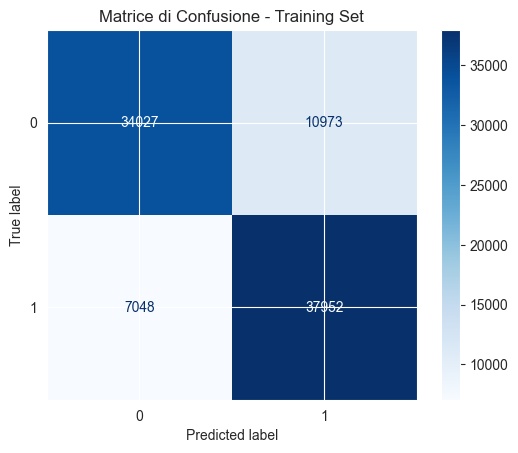

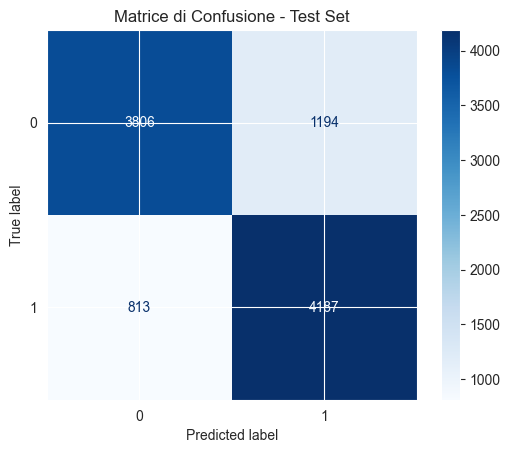

In [115]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_random_forest_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_random_forest"
os.makedirs(checkpoint_dir, exist_ok=True)

# Configura Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definizione dei parametri per il Grid Search
param_grid = {
    "n_estimators": [50, 100, 200],       # Numero di alberi nella foresta
    "max_depth": [None, 10, 20],          # Profondità massima
    "min_samples_split": [2, 10, 20]     # Minimo numero di campioni per suddividere un nodo
}

# Inizializza il modello Random Forest
model = RandomForestClassifier(random_state=42)

# Configura il Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,                # Usa StratifiedKFold come validazione incrociata
    scoring="accuracy",   # Metrica da ottimizzare
    n_jobs=-1,            # Usa tutti i processori disponibili
    verbose=2             # Stampa il progresso
)

# Esegui il Grid Search con i dati bilanciati
grid_search.fit(X, y)

# Migliori parametri trovati
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Calcolo della matrice di confusione sul miglior modello
train_index, test_index = next(iter(kf.split(X, y)))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Addestra il miglior modello trovato con Grid Search
best_model.fit(X_train, y_train)

# Matrice di confusione sul training set
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()

Fitting 10 folds for each of 54 candidates, totalling 540 fits

Migliori parametri trovati:
{'criterion': 'gini', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Miglior modello salvato: best_checkpoint_random_forest/best_random_forest_model.pkl

Accuratezza sul Test Set Separato: 0.8101

Classification Report:
              precision    recall  f1-score   support

    Classe 0       0.86      0.74      0.80     10000
    Classe 1       0.77      0.88      0.82     10000

    accuracy                           0.81     20000
   macro avg       0.82      0.81      0.81     20000
weighted avg       0.82      0.81      0.81     20000



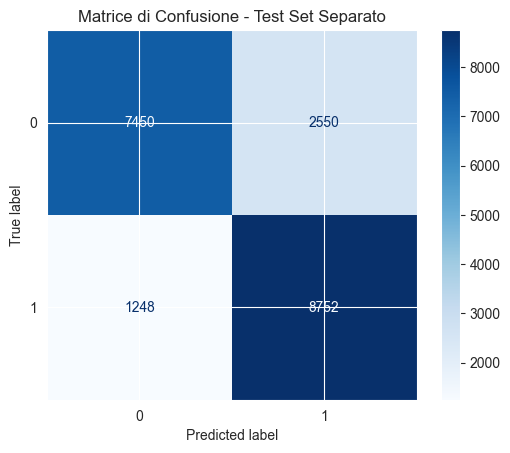

In [139]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import GridSearchCV
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_random_forest_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_random_forest"
os.makedirs(checkpoint_dir, exist_ok=True)

# Definizione dei parametri per il Grid Search
param_grid = {
    "criterion": ["gini", "entropy"],
    "n_estimators": [50, 100, 200],       # Numero di alberi nella foresta
    "max_depth": [None, 10, 20],          # Profondità massima
    "min_samples_split": [2, 10, 20]     # Minimo numero di campioni per suddividere un nodo
}

# Inizializza il modello Random Forest
model = RandomForestClassifier(random_state=42)

# Configura il Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,                # 5-fold cross validation sul training set
    scoring="accuracy",  # Metrica da ottimizzare
    n_jobs=-1,           # Usa tutti i processori disponibili
    verbose=2            # Stampa il progresso
)

# Esegui il Grid Search con il training/validation set
grid_search.fit(X_train_val, y_train_val)

# Migliori parametri trovati
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Valutazione sul test set separato
y_test_pred = best_model.predict(X_test)

# Accuratezza sul test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAccuratezza sul Test Set Separato: {test_accuracy:.4f}")

# Classification report sul test set
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Classe 0", "Classe 1"]))

# Matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set Separato")
plt.show()


# Logistic Regression

Fitting 10 folds for each of 24 candidates, totalling 240 fits

Migliori parametri trovati:
{'C': 0.1, 'max_iter': 4000, 'penalty': 'l1', 'solver': 'saga'}
Accuratezza media del miglior modello: 0.5225
Miglior modello salvato: best_checkpoint_logistic_regression/best_logistic_regression_model.pkl


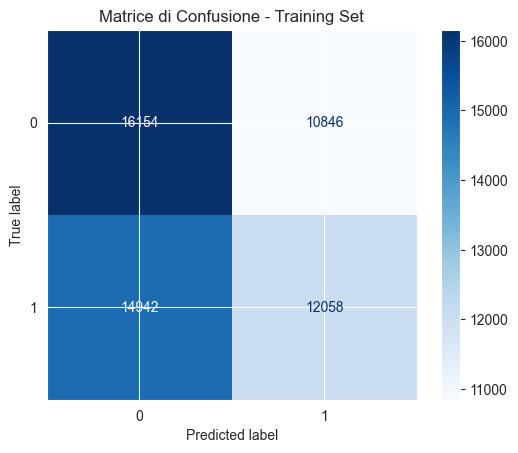

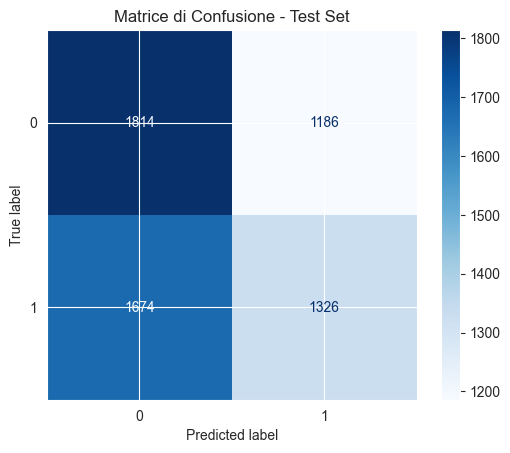

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, GridSearchCV
import os
import joblib
import matplotlib.pyplot as plt

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_logistic_regression_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_logistic_regression"
os.makedirs(checkpoint_dir, exist_ok=True)

# Definizione dei parametri per il Grid Search
param_grid = [
    {"penalty": ["l1"], "C": [0.01, 0.1, 1, 10], "solver": ["saga"], "max_iter": [4000]},
    {"penalty": ["l2"], "C": [0.01, 0.1, 1, 10], "solver": ["saga", "lbfgs"], "max_iter": [4000]},
    {"penalty": ["elasticnet"], "C": [0.01, 0.1, 1, 10], "solver": ["saga"], "l1_ratio": [0.1, 0.5, 0.9], "max_iter": [2000]}
]

# Inizializza il modello Logistic Regression
model = LogisticRegression(random_state=42)

# Configura il Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,                # Usa StratifiedKFold come validazione incrociata
    scoring="accuracy",   # Metrica da ottimizzare
    n_jobs=-1,            # Usa tutti i processori disponibili
    verbose=2             # Stampa il progresso
)

# Esegui il Grid Search con i dati bilanciati
grid_search.fit(X, y)

# Migliori parametri trovati
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Matrice di confusione sul training set per il miglior modello
train_index, test_index = next(iter(kf.split(X, y)))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

best_model.fit(X_train, y_train)
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set per il miglior modello
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()

# La Logistic Regression è un modello di classificazione semplice. Motivi per cui potrebbe non essere adeguata:
# I dati potrebbero essero non linearmente separabili
# Troppe feature

# SVM

Fitting 10 folds for each of 40 candidates, totalling 400 fits
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.5s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.9s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.3s
[CV] END ...................C=0.1, gamma=auto, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.3s
[CV] END ...................C=0.1, gamma=0.01, kernel=linear; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time=   0.4s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.4s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .........................C=0.1, gamma

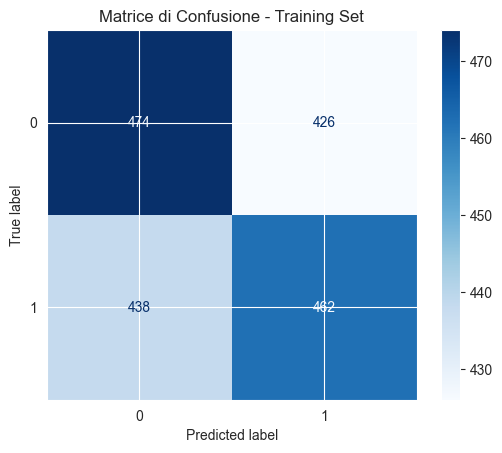

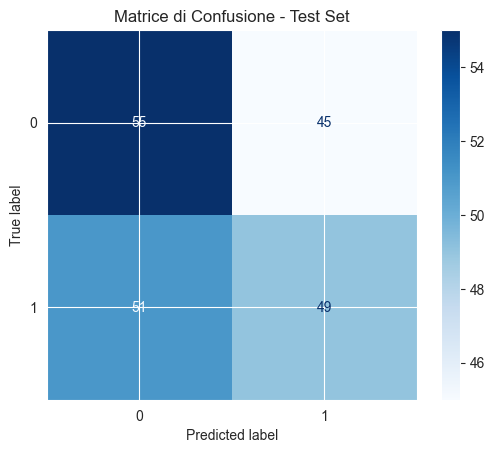

In [54]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior checkpoint
def save_best_checkpoint(model):
    filename = f"{checkpoint_dir}/best_svm_model.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Cartella per salvare il miglior modello
checkpoint_dir = "best_checkpoint_svm"
os.makedirs(checkpoint_dir, exist_ok=True)

# Configura Stratified K-Fold Cross Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definizione dei parametri per il Grid Search
param_grid = {
    'C': [0.1, 1, 10, 100],        # Parametro di penalizzazione
    'kernel': ['linear', 'rbf'],    # Tipi di kernel: lineare o RBF (Radial Basis Function)
    'gamma': ['scale', 'auto', 0.01, 0.1, 1],     # Parametro del kernel RBF
}

# Inizializza il modello SVM
model = SVC(random_state=42, probability=True)

# Configura il Grid Search
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=kf,                # Usa StratifiedKFold come validazione incrociata
    scoring="accuracy",  # Metrica da ottimizzare
    n_jobs=-1,            # Usa tutti i processori disponibili
    verbose=2             # Stampa il progresso
)

# Esegui il Grid Search con i dati bilanciati
grid_search.fit(X, y)

# Migliori parametri trovati
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Matrice di confusione sul training e test set per il miglior modello
train_index, test_index = next(iter(kf.split(X, y)))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

best_model.fit(X_train, y_train)
y_train_pred_best = best_model.predict(X_train)
y_test_pred_best = best_model.predict(X_test)

train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)

# Visualizza la matrice di confusione per il training set
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Visualizza la matrice di confusione per il test set
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


# AdaBoostClassifier

In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior modello
def save_best_model(model):
    filename = "best_adaboost_model_grid_search.pkl"
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100, 150],         # Numero di estimatori
    'learning_rate': [0.01, 0.1, 1.0],     # Tasso di apprendimento
    'estimator': [                         # Diversi stimatori di base
        DecisionTreeClassifier(max_depth=20),  # Stump decision tree
        DecisionTreeClassifier(max_depth=50),  # Albero con profondità massima 2
        LogisticRegression(max_iter=1000),    # Regressione logistica
        # SVC(probability=True, kernel='linear')  # SVM con kernel lineare
    ]
}

# Inizializza il modello AdaBoost
adaboost = AdaBoostClassifier(random_state=42, algorithm="SAMME")

# GridSearchCV
grid_search = GridSearchCV(
    estimator=adaboost,
    param_grid=param_grid,
    cv=kf,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Addestra il modello usando GridSearchCV
grid_search.fit(X, y)

# Risultati della grid search
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Salva il miglior modello come checkpoint
best_model = grid_search.best_estimator_
save_best_checkpoint(best_model)

# Calcolo della matrice di confusione sul miglior modello
train_index, test_index = next(iter(kf.split(X, y)))
X_train, X_test = X.iloc[train_index], X.iloc[test_index]
y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Addestra il miglior modello trovato con Grid Search
best_model.fit(X_train, y_train)

# Matrice di confusione sul training set
y_train_pred_best = best_model.predict(X_train)
train_conf_matrix = confusion_matrix(y_train, y_train_pred_best)
disp_train = ConfusionMatrixDisplay(confusion_matrix=train_conf_matrix, display_labels=best_model.classes_)
disp_train.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Training Set")
plt.show()

# Matrice di confusione sul test set
y_test_pred_best = best_model.predict(X_test)
test_conf_matrix = confusion_matrix(y_test, y_test_pred_best)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()



Fitting 10 folds for each of 27 candidates, totalling 270 fits

Migliori parametri trovati:
{'estimator': DecisionTreeClassifier(max_depth=20), 'learning_rate': 1.0, 'n_estimators': 50}
Accuratezza media del miglior modello: 0.9431


NameError: name 'save_best_checkpoint' is not defined

Fitting 10 folds for each of 27 candidates, totalling 270 fits

Migliori parametri trovati:
{'estimator': DecisionTreeClassifier(max_depth=10), 'learning_rate': 1.0, 'n_estimators': 50}
Accuratezza media del miglior modello: 0.9492
Miglior modello salvato: best_adaboost_model_grid_search.pkl

** Risultati sul Test Set **
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      2000
           1       0.99      0.89      0.94      2000

    accuracy                           0.94      4000
   macro avg       0.95      0.94      0.94      4000
weighted avg       0.95      0.94      0.94      4000

Accuratezza sul Test Set: 0.9417


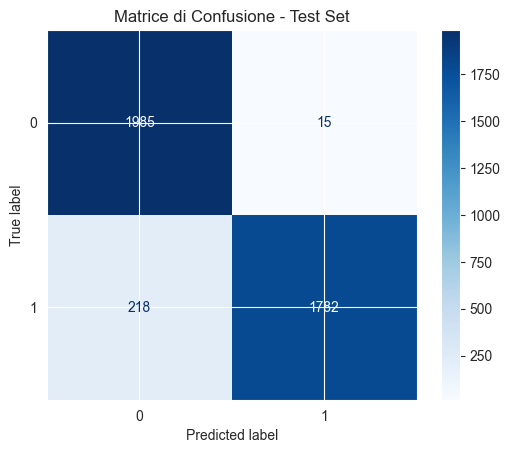

In [23]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import joblib

# Funzione per salvare il miglior modello
def save_best_model(model, filename="best_adaboost_model_grid_search.pkl"):
    joblib.dump(model, filename)
    print(f"Miglior modello salvato: {filename}")

# Griglia degli iperparametri
param_grid = {
    'n_estimators': [50, 100, 150],         # Numero di estimatori
    'learning_rate': [0.01, 0.1, 1.0],     # Tasso di apprendimento
    'estimator': [                    # Diversi stimatori di base
        DecisionTreeClassifier(max_depth=5), 
        DecisionTreeClassifier(max_depth=10),
        LogisticRegression(max_iter=1000, random_state=42)
    ]
}

# Inizializza il modello AdaBoost
adaboost = AdaBoostClassifier(random_state=42, algorithm="SAMME")

# GridSearchCV
grid_search = GridSearchCV(
    estimator=adaboost,
    param_grid=param_grid,
    cv=kf,  # K-Fold Cross Validation (già definito)
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# Esegui la GridSearch sul training set
grid_search.fit(X_train_val, y_train_val)

# Risultati della Grid Search
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Salva il miglior modello trovato
best_model = grid_search.best_estimator_
save_best_model(best_model)

# Valutazione finale sul test set
y_test_pred = best_model.predict(X_test)

# Report di classificazione
print("\n** Risultati sul Test Set **")
print(classification_report(y_test, y_test_pred))
print(f"Accuratezza sul Test Set: {accuracy_score(y_test, y_test_pred):.4f}")

# Matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_model.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()


# KNN

Fitting 10 folds for each of 60 candidates, totalling 600 fits

Migliori parametri trovati:
{'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'uniform'}
Accuratezza media del miglior modello: 0.9771

Accuratezza sul Test Set: 0.9781

Classification Report:
              precision    recall  f1-score   support

    Classe 0       0.96      1.00      0.98     10000
    Classe 1       1.00      0.96      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



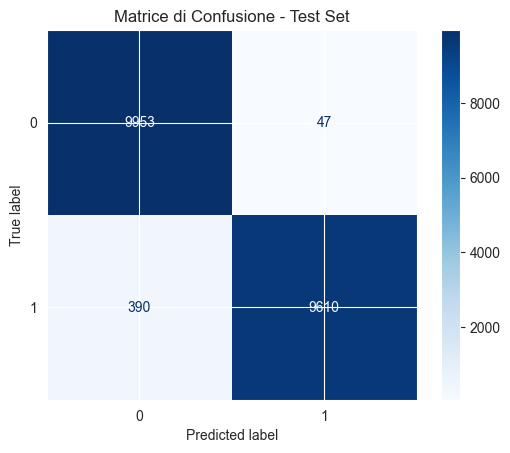

In [30]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np

# Griglia degli iperparametri per il KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11],      # Numero di vicini
    'weights': ['uniform', 'distance'],   # Peso dei vicini (uniforme o in base alla distanza)
    'metric': ['euclidean', 'manhattan', 'minkowski'],  # Diverse metriche di distanza
    'p': [1, 2]                           # Parametro p per Minkowski (1 = manhattan, 2 = euclidean)
}

# Inizializza il modello KNN
knn = KNeighborsClassifier()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=knn,
    param_grid=param_grid,
    cv=kf,                        # K-Fold Cross Validation definito precedentemente
    scoring='accuracy',           # Metrica per valutare le performance
    n_jobs=-1,                    # Utilizza tutti i core disponibili
    verbose=1                     # Mostra i dettagli durante la ricerca
)

# Esegui la Grid Search sul training set
grid_search.fit(X_train_val, y_train_val)

# Risultati della Grid Search
print("\nMigliori parametri trovati:")
print(grid_search.best_params_)
print(f"Accuratezza media del miglior modello: {grid_search.best_score_:.4f}")

# Estrai il miglior modello dalla Grid Search
best_knn = grid_search.best_estimator_

# Valutazione finale sul test set
y_test_pred = best_knn.predict(X_test)

# Accuratezza sul test set
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"\nAccuratezza sul Test Set: {test_accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=["Classe 0", "Classe 1"]))

# Matrice di confusione sul test set
test_conf_matrix = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_conf_matrix, display_labels=best_knn.classes_)
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Matrice di Confusione - Test Set")
plt.show()
